In [19]:
import pandas as pd

otu_df = pd.read_csv('dataframes/OTU.txt', sep='\t')
hiera_blast = pd.read_csv('dataframes/hiera_BLAST.txt', sep='\t')
meta_map = pd.read_csv('dataframes/MCOSIS_map.txt', sep='\t')
meta = pd.read_csv('dataframes/antibiotics kazakh finished.csv', sep='\t')

In [20]:
meta = meta[['ID', 'sample', 'day of research', 'intervention']]
meta_map_expanded = meta_map.set_index('#SampleID').fastqFile.str.split(',', expand=True).stack().reset_index(name='fastqFile').drop('level_1', axis=1)

# Соединение таблиц
merged = pd.merge(meta, meta_map_expanded, left_on='ID', right_on='fastqFile')

# Замена старых значений 'ID' на новые из '#SampleID'
meta['ID'] = merged['#SampleID']

# Показываем результат
meta.head()


,ID,sample,day of research,intervention
0,SMPL0,1,40,yes
1,SMPL1,1,45,yes
2,SMPL2,1,50,yes
3,SMPL3,1,55,yes
4,SMPL4,1,60,yes


In [21]:
# Транспонирование otu_df
otu_df_transposed = otu_df.set_index('OTU').T
otu_df_transposed = otu_df_transposed.reset_index().rename(columns={'index': 'SampleID'})

# Переименование столбцов в meta для соответствия с otu_df_transposed
meta = meta.rename(columns={'ID': 'SampleID', 'intervention': 'GROUP'})

# Объединение таблиц
merged_df = pd.merge(meta, otu_df_transposed, on='SampleID')

# Переименование столбцов OTU
for col in merged_df.columns:
    if 'OTU' in col:
        merged_df = merged_df.rename(columns={col: col.replace('OTU_', 'OTU')})

# Вывод результата
merged_df = merged_df.drop(columns=['sample', 'day of research'])
merged_df.to_csv('dataframes/output/otu/otu_starting.csv', sep='\t')
merged_df.head()

,SampleID,GROUP,OTU1,OTU2,OTU3,OTU4,OTU5,OTU6,OTU7,OTU8,...,OTU4190,OTU4191,OTU4192,OTU4193,OTU4194,OTU4195,OTU4196,OTU4197,OTU4198,OTU4199
0,SMPL0,yes,12,0,26,0,14,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1,SMPL1,yes,416,60,672,1,1641,59,0,33,...,0,0,0,0,0,0,0,0,0,0
2,SMPL2,yes,101,8,7,0,567,1,0,11,...,0,0,0,0,0,0,0,0,0,0
3,SMPL3,yes,3161,1505,11,0,3890,1,3,64,...,0,0,0,0,0,0,0,0,0,0
4,SMPL4,yes,15,3,2,8,123,2,1,2,...,0,0,0,0,0,0,0,0,0,0


In [22]:
group_counts = merged_df['GROUP'].value_counts()
group_counts

GROUP
no     60
yes    52
Name: count, dtype: int64

In [23]:
for col in hiera_blast.columns[1:]: 
    hiera_blast[col] = col[0].lower() + '_' + hiera_blast[col]

hiera_blast['OTU'] = hiera_blast['OTU'].str.replace('_', '')

hiera_blast['Taxonomy'] = hiera_blast['Domain'] + '|' + \
                        hiera_blast['Phylum'] + '|' + \
                        hiera_blast['Class'] + '|' + \
                        hiera_blast['Order'] + '|' + \
                        hiera_blast['Family'] + '|' + \
                        hiera_blast['Genus'] + '|' + \
                        hiera_blast['Species']

hiera_blast = hiera_blast[['OTU', 'Taxonomy']]

hiera_blast.head()


,OTU,Taxonomy
0,OTU4155,d_Bacteria|p_Bacteroidetes|c_Bacteroidia|o_Bac...
1,OTU4149,d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostri...
2,OTU4093,d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostri...
3,OTU4078,d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostri...
4,OTU4073,d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostri...


In [24]:
long_merged_df = pd.melt(merged_df, id_vars=['SampleID', 'GROUP'], var_name='OTU', value_name='Value')

# Объединяем hiera_blast с long_merged_df по столбцу 'OTU'
merged_result = pd.merge(hiera_blast, long_merged_df, on='OTU', how='inner')

merged_result

,OTU,Taxonomy,SampleID,GROUP,Value
0,OTU4155,d_Bacteria|p_Bacteroidetes|c_Bacteroidia|o_Bac...,SMPL0,yes,0
1,OTU4155,d_Bacteria|p_Bacteroidetes|c_Bacteroidia|o_Bac...,SMPL1,yes,0
2,OTU4155,d_Bacteria|p_Bacteroidetes|c_Bacteroidia|o_Bac...,SMPL2,yes,0
3,OTU4155,d_Bacteria|p_Bacteroidetes|c_Bacteroidia|o_Bac...,SMPL3,yes,0
4,OTU4155,d_Bacteria|p_Bacteroidetes|c_Bacteroidia|o_Bac...,SMPL4,yes,0
...,...,...,...,...,...
113003,OTU12,d_Bacteria|p_Bacteroidetes|c_Bacteroidia|o_Bac...,SMPL107,no,0
113004,OTU12,d_Bacteria|p_Bacteroidetes|c_Bacteroidia|o_Bac...,SMPL108,no,0
113005,OTU12,d_Bacteria|p_Bacteroidetes|c_Bacteroidia|o_Bac...,SMPL109,no,0
113006,OTU12,d_Bacteria|p_Bacteroidetes|c_Bacteroidia|o_Bac...,SMPL110,no,0


In [25]:
# Удаление всех строк, которые не содержат 'Collinsella' в столбце 'Taxonomy'
filtered_result = merged_result[merged_result['Taxonomy'].str.contains('Collinsella', na=False)]

filtered_result

,OTU,Taxonomy,SampleID,GROUP,Value
92624,OTU209,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL0,yes,0
92625,OTU209,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL1,yes,0
92626,OTU209,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL2,yes,0
92627,OTU209,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL3,yes,3
92628,OTU209,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL4,yes,0
...,...,...,...,...,...
97995,OTU115,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL107,no,0
97996,OTU115,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL108,no,0
97997,OTU115,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL109,no,0
97998,OTU115,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL110,no,0


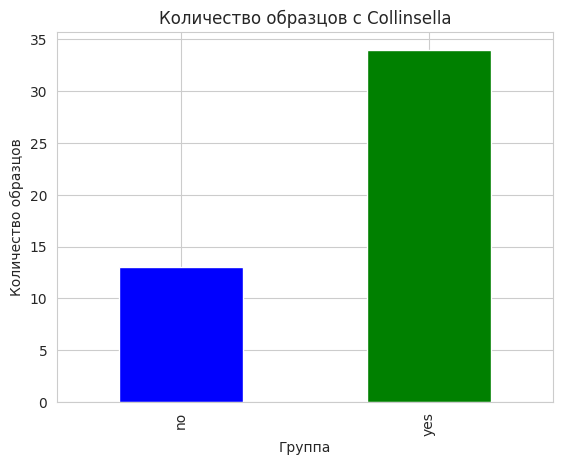

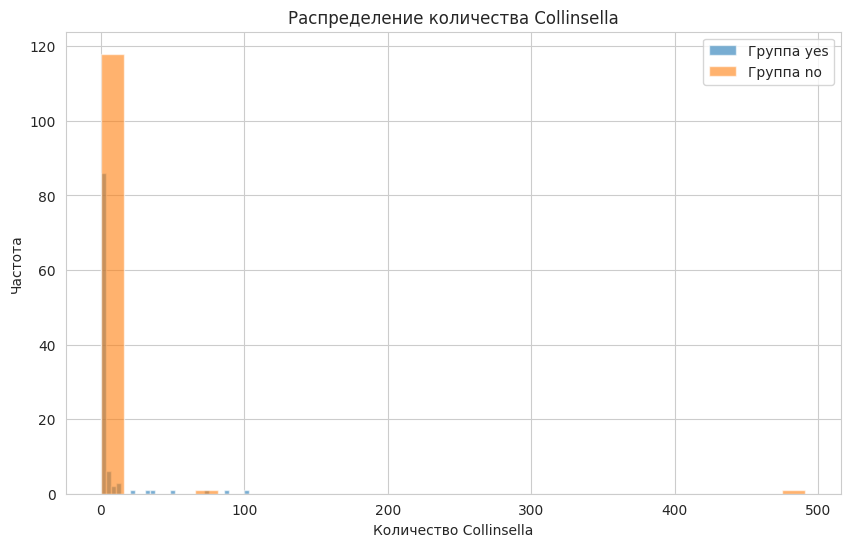

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Анализ: Подсчет количества образцов с ненулевым количеством бактерий 'Collinsella'
non_zero_collinsella = filtered_result[filtered_result['Value'] > 0]
count_by_group = non_zero_collinsella.groupby('GROUP')['SampleID'].count()

# Визуализация 1: Количество образцов с 'Collinsella' в каждой группе
count_by_group.plot(kind='bar', color=['blue', 'green'])
plt.title('Количество образцов с Collinsella')
plt.xlabel('Группа')
plt.ylabel('Количество образцов')
plt.show()

# Визуализация 2: Распределение количества бактерий 'Collinsella' в образцах
plt.figure(figsize=(10, 6))
for group in filtered_result['GROUP'].unique():
    subset = filtered_result[filtered_result['GROUP'] == group]
    plt.hist(subset['Value'], bins=30, label=f'Группа {group}', alpha=0.6)

plt.title('Распределение количества Collinsella')
plt.xlabel('Количество Collinsella')
plt.ylabel('Частота')
plt.legend()
plt.show()


In [27]:
non_zero_collinsella

,OTU,Taxonomy,SampleID,GROUP,Value
92627,OTU209,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL3,yes,3
92641,OTU209,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL17,yes,89
92642,OTU209,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL18,yes,4
92643,OTU209,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL19,yes,24
92644,OTU209,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL20,yes,2
92645,OTU209,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL21,yes,2
92647,OTU209,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL23,yes,1
92649,OTU209,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL25,yes,1
92650,OTU209,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL26,yes,10
92656,OTU209,d_Bacteria|p_Actinobacteria|c_Coriobacteriia|o...,SMPL32,yes,1


In [28]:
import pandas as pd
from scipy.stats import mannwhitneyu


def statics(df):
    # Фильтруем данные по группам
    group_yes = df[df['GROUP'] == 'yes']['Value']
    group_no = df[df['GROUP'] == 'no']['Value']

    # Проверка, что в каждой группе есть хотя бы два наблюдения
    if len(group_yes) > 1 and len(group_no) > 1:
        # Расчет p-value с помощью Mann-Whitney U теста
        u_statistic, p_value = mannwhitneyu(group_yes, group_no, alternative='two-sided')
        print(f'U-Statistic mannwhitneyu: {u_statistic}')
        print(f'p-value mannwhitneyu: {p_value}')
    else:
        print("Одна из групп содержит слишком мало значений для анализа.")

    from scipy.stats import ttest_ind

    t_stat, p_value_t_test = ttest_ind(group_yes, group_no, equal_var=False)  # equal_var=False для Welch's t-test
    print(f'T-Statistic Welch\'s t-test: {t_stat}')
    print(f'p-value (T-test) Welch\'s t-test: {p_value_t_test}')

    from scipy.stats import kruskal

    kruskal_stat, p_value_kruskal = kruskal(group_yes, group_no)
    print(f'Kruskal-Wallis Statistic: {kruskal_stat}')
    print(f'p-value (Kruskal-Wallis): {p_value_kruskal}')

    from scipy.stats import f_oneway

    f_stat, p_value_anova = f_oneway(group_yes, group_no)
    print(f'F-Statistic (ANOVA): {f_stat}')
    print(f'p-value (ANOVA): {p_value_anova}')

    from mlxtend.evaluate import permutation_test

    p_value_permutation = permutation_test(group_yes, group_no, method='approximate', num_rounds=10000, seed=0)
    print(f'p-value (Permutation test): {p_value_permutation}')

statics(non_zero_collinsella)


U-Statistic mannwhitneyu: 290.0
p-value mannwhitneyu: 0.09478576583732774
T-Statistic Welch's t-test: -0.783335531261259
p-value (T-test) Welch's t-test: 0.44820663025581253
Kruskal-Wallis Statistic: 2.8320525751905565
p-value (Kruskal-Wallis): 0.09240019481079234
F-Statistic (ANOVA): 1.533378444875182
p-value (ANOVA): 0.2220273698294001
p-value (Permutation test): 0.2298770122987701


In [29]:
statics(filtered_result)

U-Statistic mannwhitneyu: 7673.0
p-value mannwhitneyu: 3.150398486486511e-05
T-Statistic Welch's t-test: 0.0230261839165999
p-value (T-test) Welch's t-test: 0.9816593012827008
Kruskal-Wallis Statistic: 17.33694734597314
p-value (Kruskal-Wallis): 3.130409352477894e-05
F-Statistic (ANOVA): 0.0004747336843337586
p-value (ANOVA): 0.9826363309093253
p-value (Permutation test): 0.998000199980002


In [30]:
merged_result_non_zero = merged_result[merged_result['Value'] > 0]
statics(merged_result_non_zero)

U-Statistic mannwhitneyu: 15527003.5


p-value mannwhitneyu: 0.0008018319873763363
T-Statistic Welch's t-test: 1.2482575548405381
p-value (T-test) Welch's t-test: 0.21196341264502466
Kruskal-Wallis Statistic: 11.237007927192957
p-value (Kruskal-Wallis): 0.0008018231306330752
F-Statistic (ANOVA): 1.527231630042316
p-value (ANOVA): 0.2165548369569358
p-value (Permutation test): 0.21607839216078392


In [31]:
import pandas as pd
taxonomy_df = pd.DataFrame(merged_result_non_zero['Taxonomy'])
taxonomy_df.dropna(inplace=True)
nan_rows = taxonomy_df[taxonomy_df['Taxonomy'].isna()]
print(nan_rows)

Empty DataFrame
Columns: [Taxonomy]
Index: []


In [32]:
merged_result_non_zero.head()

,OTU,Taxonomy,SampleID,GROUP,Value
64,OTU4155,d_Bacteria|p_Bacteroidetes|c_Bacteroidia|o_Bac...,SMPL64,yes,2
122,OTU4149,d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostri...,SMPL10,no,2
245,OTU4093,d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostri...,SMPL21,yes,2
372,OTU4078,d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostri...,SMPL36,no,1
374,OTU4078,d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostri...,SMPL38,no,1


In [33]:
import pandas as pd

data = merged_result_non_zero.copy()

# Создание нового столбца 'Sample_Group'
data['Sample_Group'] = data['SampleID'] + '_' + data['GROUP']

# Создание сводной таблицы
pivot_df = data.pivot_table(index='Taxonomy', columns='Sample_Group', values='Value', aggfunc='sum', fill_value=0)

# Сброс индекса, чтобы 'Taxonomy' стал столбцом
pivot_df.reset_index(inplace=True)

# Вывод первых нескольких строк полученного DataFrame для проверки
pivot_df.head()

Sample_Group,Taxonomy,SMPL0_yes,SMPL100_no,SMPL101_no,SMPL102_no,SMPL103_no,SMPL104_no,SMPL105_no,SMPL106_yes,SMPL107_no,...,SMPL91_yes,SMPL92_yes,SMPL93_no,SMPL94_no,SMPL95_no,SMPL96_no,SMPL97_no,SMPL98_yes,SMPL99_yes,SMPL9_no
0,d_Bacteria|p_?|c_?|o_?|f_?|g_?|s_?,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,d_Bacteria|p_Actinobacteria|c_Actinobacteria|o...,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,d_Bacteria|p_Actinobacteria|c_Actinobacteria|o...,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,2,0
3,d_Bacteria|p_Actinobacteria|c_Actinobacteria|o...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,92,0
4,d_Bacteria|p_Actinobacteria|c_Actinobacteria|o...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/tmp/ipykernel_5578/4160183979.py:44: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = ttest_ind(yes_values, no_values, nan_policy='omit')


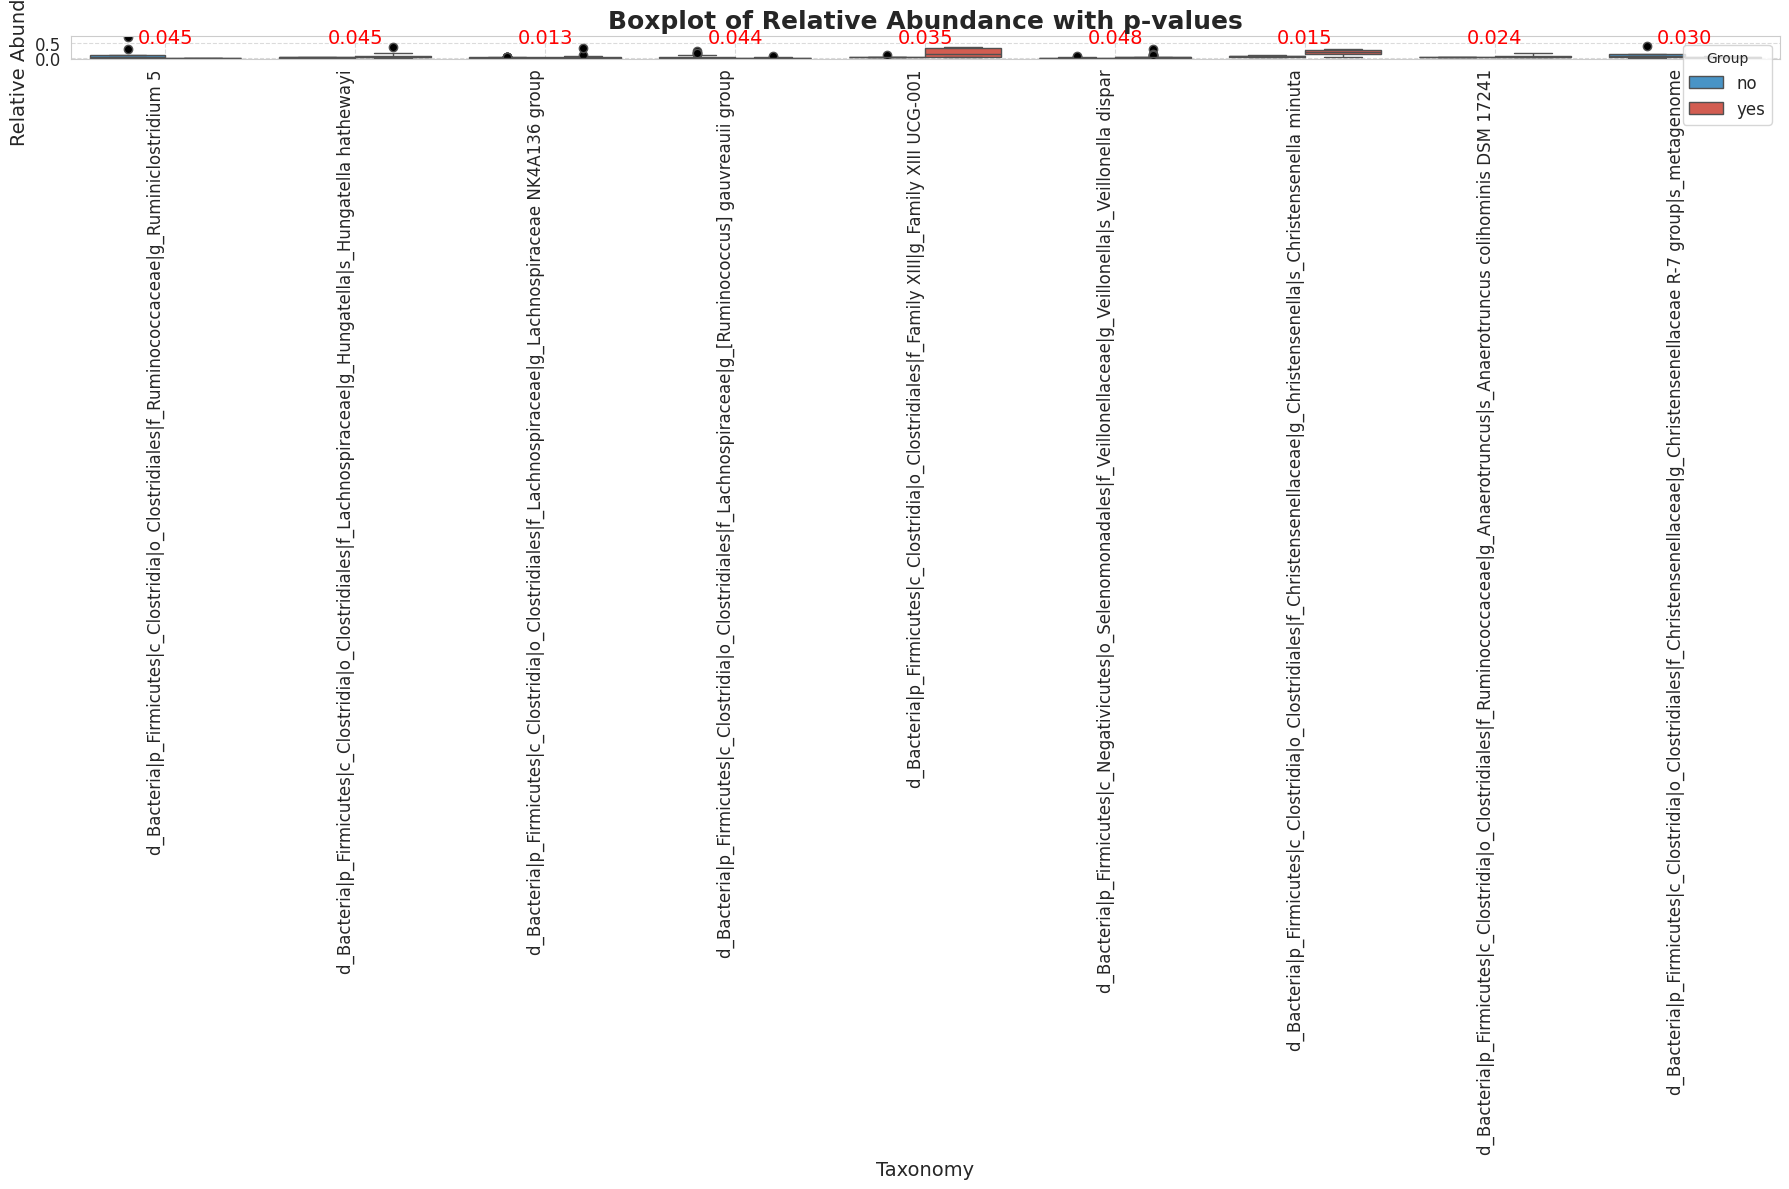

Таксон: d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostridiales|f_Ruminococcaceae|g_Ruminiclostridium 5, p-value: 0.0453
Таксон: d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostridiales|f_Lachnospiraceae|g_Hungatella|s_Hungatella hathewayi, p-value: 0.0448
Таксон: d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostridiales|f_Lachnospiraceae|g_Lachnospiraceae NK4A136 group, p-value: 0.0130
Таксон: d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostridiales|f_Lachnospiraceae|g_[Ruminococcus] gauvreauii group, p-value: 0.0439
Таксон: d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostridiales|f_Family XIII|g_Family XIII UCG-001, p-value: 0.0348
Таксон: d_Bacteria|p_Firmicutes|c_Negativicutes|o_Selenomonadales|f_Veillonellaceae|g_Veillonella|s_Veillonella dispar, p-value: 0.0479
Таксон: d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostridiales|f_Christensenellaceae|g_Christensenella|s_Christensenella minuta, p-value: 0.0151
Таксон: d_Bacteria|p_Firmicutes|c_Clostridia|o_Clostridiales|f_Ruminococcaceae|g_Anaerotruncus|s_An

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

def rename_taxa(row):
    parts = row.split('|')
    cleaned_parts = [part for part in parts if not part.endswith('_?')]
    return '|'.join(cleaned_parts)

pivot_df['Taxonomy'] = pivot_df['Taxonomy'].apply(rename_taxa)
#pivot_df['Taxonomy'] = pivot_df['Taxonomy'].str.split('|').str[-1]

# Рассчитываем относительное изобилие для каждого таксона в каждом образце
sample_columns = [col for col in pivot_df.columns if 'SMPL' in col]  # Измените на правильные имена столбцов
pivot_df.fillna(0, inplace=True)

relative_abundance_df = pivot_df.copy()
relative_abundance_df[sample_columns] = relative_abundance_df[sample_columns].div(relative_abundance_df[sample_columns].sum(axis=1), axis=0)

# Переупорядочиваем столбцы, чтобы "Taxonomy" был первым
relative_abundance_df = relative_abundance_df[['Taxonomy'] + sample_columns]

# Размещаем данные в "длинном" формате для boxplot
melted_df = relative_abundance_df.melt(id_vars='Taxonomy', var_name='Sample', value_name='Relative Abundance')

# Удаляем строки с Relative Abundance == 0
melted_df = melted_df[melted_df['Relative Abundance'] != 0].reset_index(drop=True)

# Определяем группы на основе названий образцов
melted_df['Group'] = melted_df['Sample'].apply(lambda x: 'yes' if 'yes' in x else 'no')

# Настройка визуализации
sns.set_style("whitegrid")
flierprops = dict(marker='o', markerfacecolor='black', markersize=6, linestyle='none')

# Расчет p-значений для каждого таксона
p_values = {}
significant_taxa = {}  # Словарь для хранения значимых таксонов и их p-значений
for taxon in melted_df['Taxonomy'].unique():
    yes_values = melted_df[(melted_df['Taxonomy'] == taxon) & (melted_df['Group'] == 'yes')]['Relative Abundance']
    no_values = melted_df[(melted_df['Taxonomy'] == taxon) & (melted_df['Group'] == 'no')]['Relative Abundance']
    
    if len(yes_values) > 1 and len(no_values) > 1:
        t_stat, p_val = ttest_ind(yes_values, no_values, nan_policy='omit')
        if p_val < 0.05:  # Фильтрация значений p по порогу 0.05
            significant_taxa[taxon] = p_val

# Фильтрация melted_df для включения только значимых таксонов
significant_melted_df = melted_df[melted_df['Taxonomy'].isin(significant_taxa.keys())]
colors = ['#3498db', '#e74c3c']
# Визуализация
plt.figure(figsize=(18, 12))
sns.boxplot(x='Taxonomy', y='Relative Abundance', hue='Group', data=significant_melted_df, palette=colors, flierprops=flierprops, whis=2, hue_order=['no','yes'])

# Добавляем значимые p-значения на график
for i, taxon in enumerate(significant_melted_df['Taxonomy'].unique()):
    p_val = significant_taxa.get(taxon)
    if p_val:  # Если таксон значим
        plt.text(i, 0.5, f"{p_val:.3f}", ha='center', color="red", size=14)

# Оформление графика
plt.xticks(rotation=90, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Taxonomy', fontsize=14)
plt.ylabel('Relative Abundance', fontsize=14)
plt.title('Boxplot of Relative Abundance with p-values', fontsize=18, fontweight='bold')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.legend(loc="upper right", fontsize=12, title="Group")
plt.tight_layout()

# Сохранение и отображение графика
plt.savefig('significant_relative_abundance_boxplot.pdf', bbox_inches = 'tight')
plt.show()

# Вывод значимых таксонов и их p-значений
for taxon, p_val in significant_taxa.items():
    print(f"Таксон: {taxon}, p-value: {p_val:.4f}")